# Introduction

## Imports and Functions

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib.style as style
from PIL import Image
import matplotlib.patches as patches
from tqdm.notebook import tqdm

from torchvision import transforms
from torchtext.data.utils import get_tokenizer


style.use('ggplot')
np.random.seed(0)

/Users/lukasreber/Repositories/del_mc2/del_mc2/lib/python3.10/site-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


# Data Analysis

In [2]:
captions = pd.read_csv('data/captions.txt')
image_path = 'data/Images'
# Get a list of all files in the directory
all_images = os.listdir(image_path)

# Nr of captions
print(f'Nr of captions: {captions.shape[0]}')
# Nr of images
print(f'Nr of images: {len(os.listdir(image_path))}')

Nr of captions: 40455
Nr of images: 8091


## Sample Images

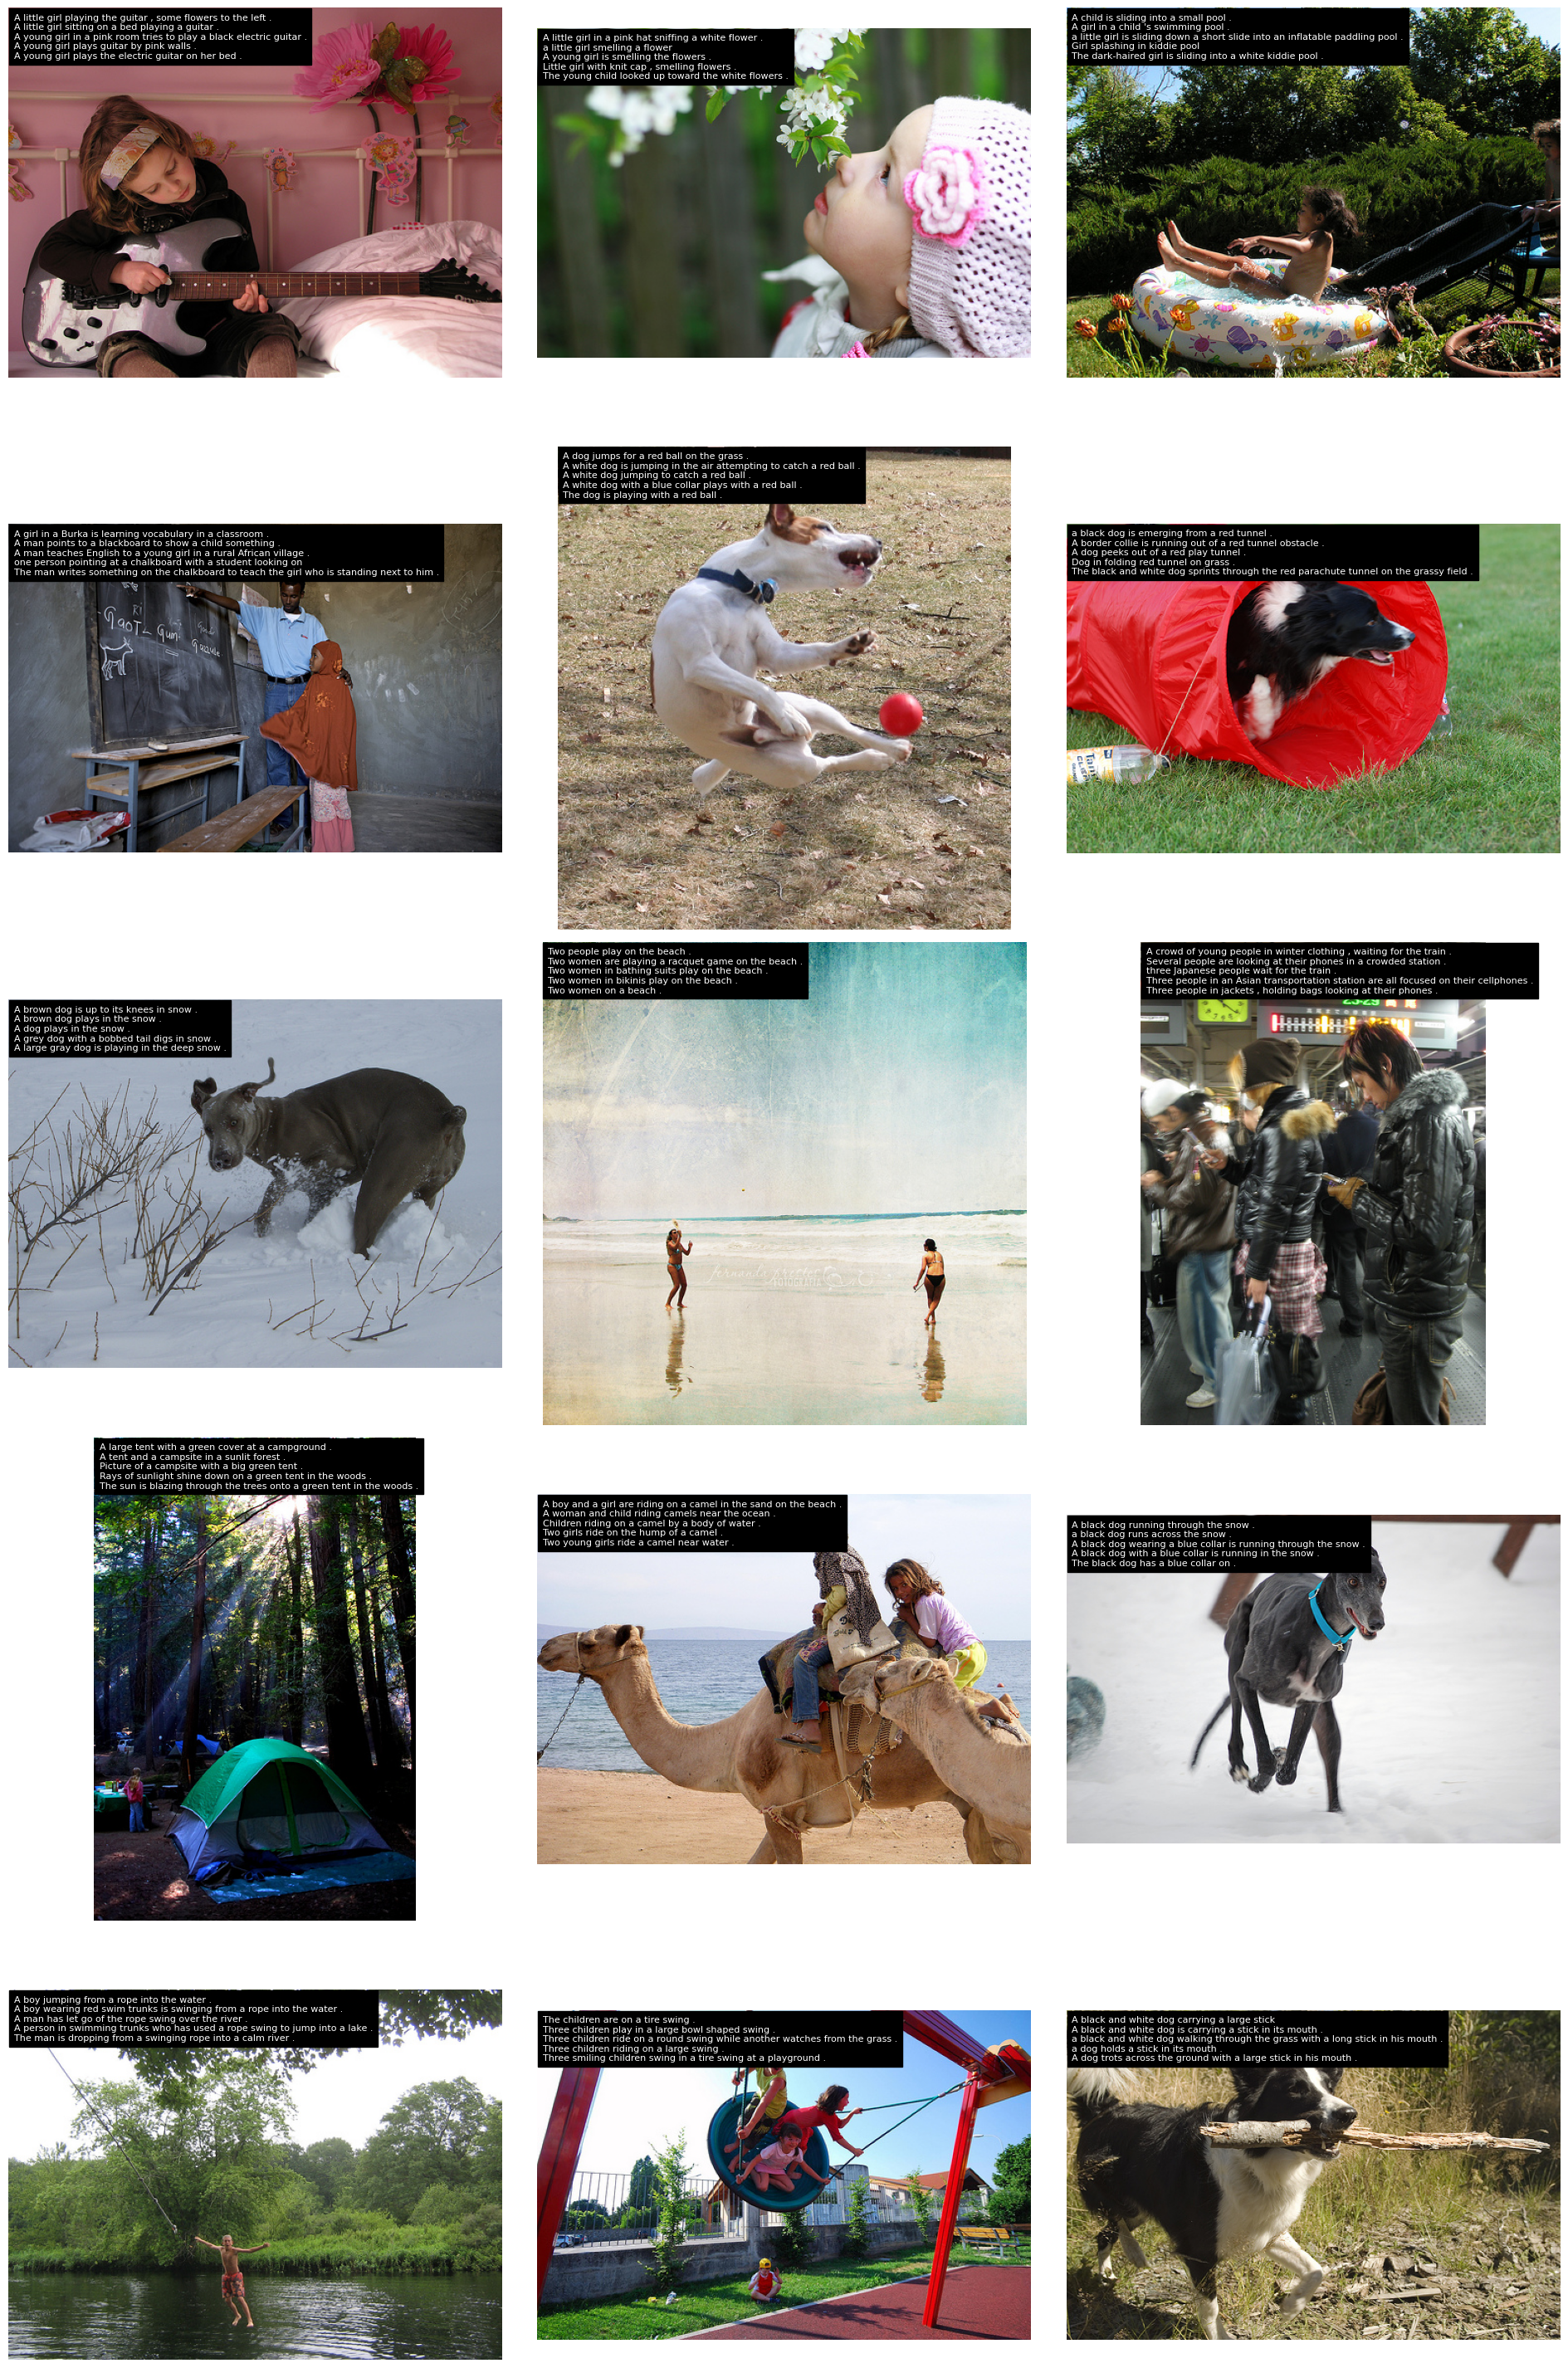

In [60]:
# display sample images with captions
fig, axs = plt.subplots(5, 3, figsize=(20, 30))

for i in axs.flatten():
    img_file = np.random.choice(os.listdir(image_path))
    img = plt.imread(os.path.join(image_path, img_file))
    i.imshow(img)
    caps = '\n'.join(captions[captions['image'] == img_file]['caption'].values)
    i.text(5, 5, caps, fontsize=8, horizontalalignment='left', verticalalignment='top', color='white', bbox=dict(facecolor='black'))
    i.axis('off')
fig.tight_layout()
plt.show()

## Caption Length

In [67]:
captions['lenght'] = captions['caption'].apply(lambda x: len(x.split()))
captions['n_characters'] = captions['caption'].apply(lambda x: len(x))

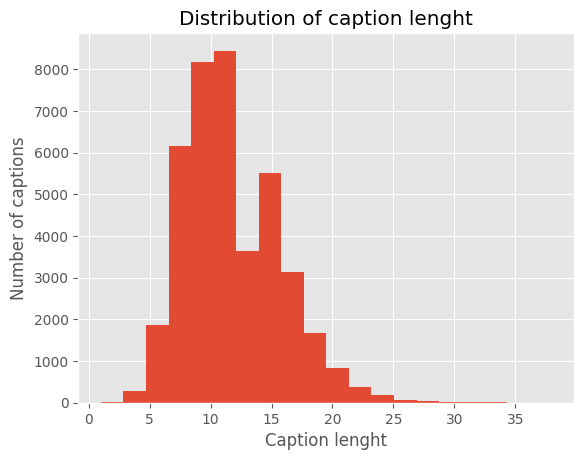

In [66]:
captions['lenght'].hist(bins=20)
plt.title('Distribution of caption lenght')
plt.xlabel('Caption lenght')
plt.ylabel('Number of captions')
plt.show()

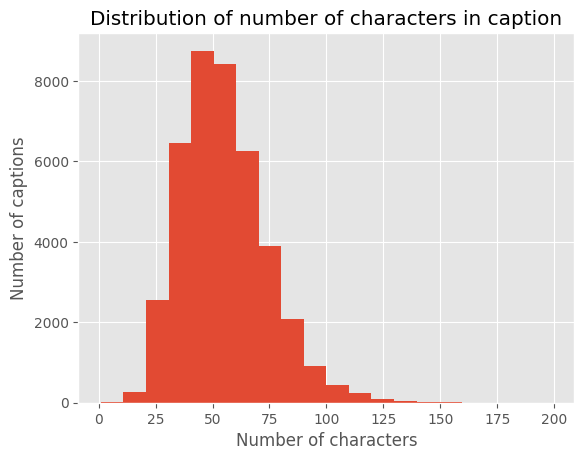

In [68]:
captions['n_characters'].hist(bins=20)
plt.title('Distribution of number of characters in caption')
plt.xlabel('Number of characters')
plt.ylabel('Number of captions')
plt.show()

## Word occurences

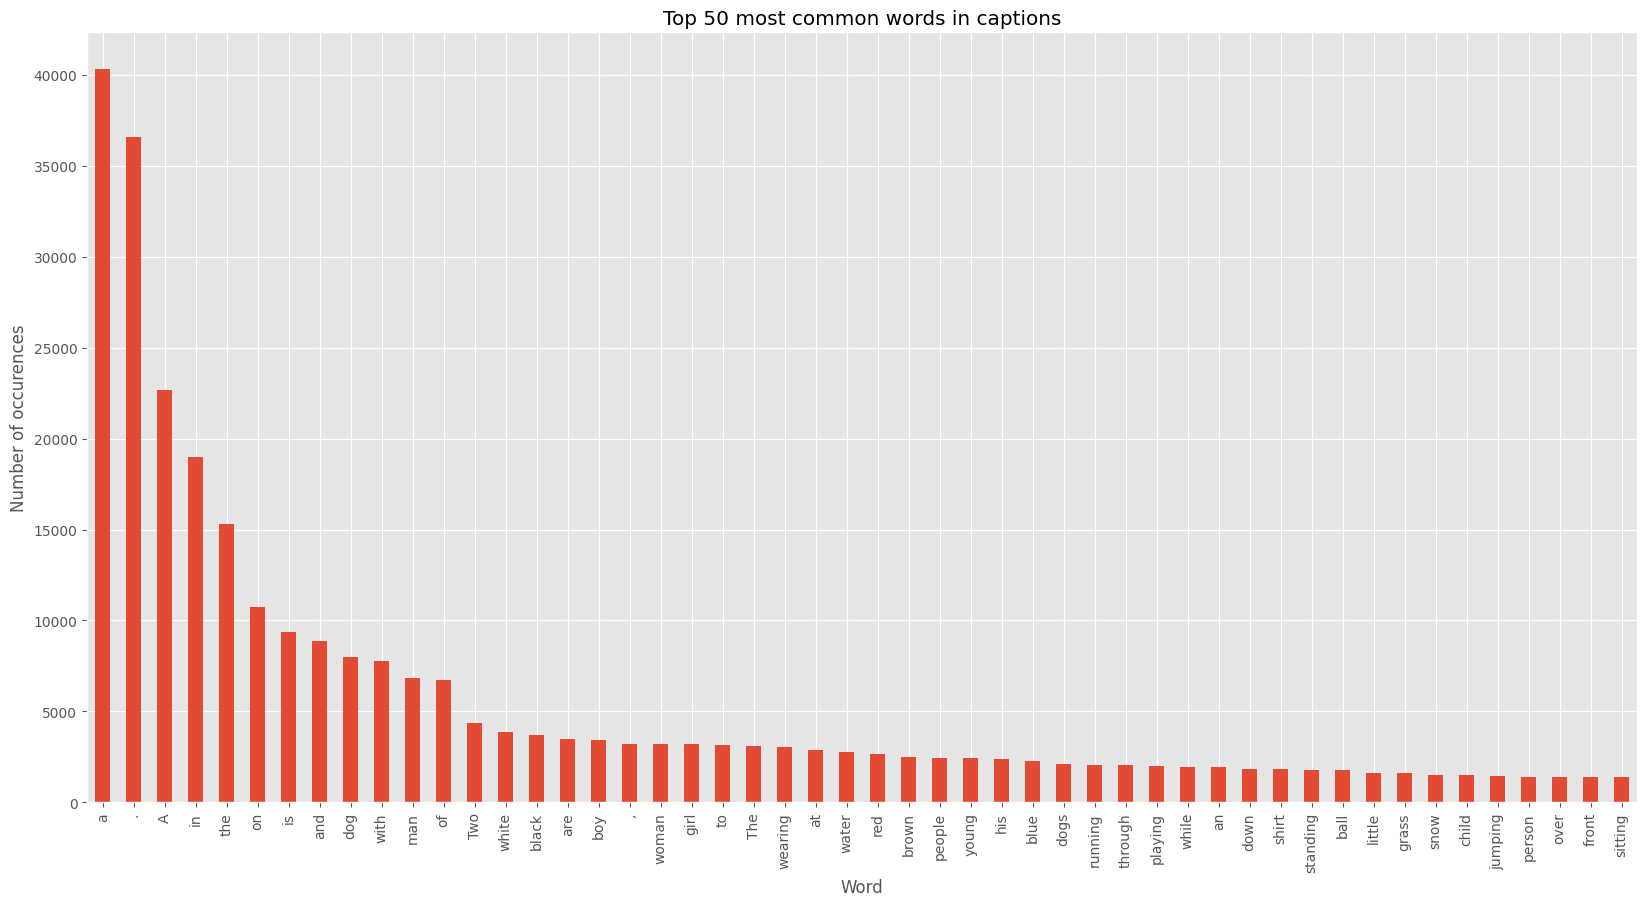

In [81]:
words = captions['caption'].str.split().sum()
words = pd.Series(words)
word_counts = words.value_counts()

word_counts.head(50).plot(kind='bar', figsize=(20, 10))
plt.title('Top 50 most common words in captions')
plt.xlabel('Word')
plt.ylabel('Number of occurences')
plt.show()

## Image Size / Ratio

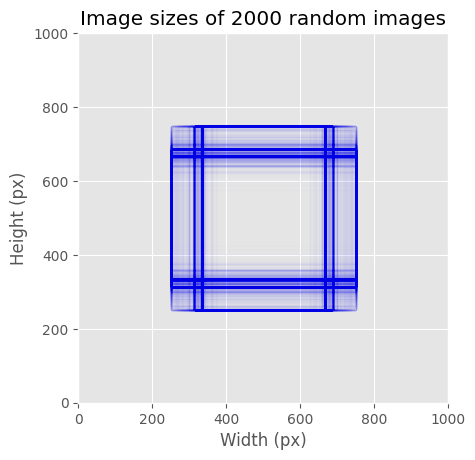

In [118]:
sample_images = np.random.choice(all_images, 2000)

fig, ax = plt.subplots(1,1)
for image in sample_images:
    img = Image.open(os.path.join(image_path, image))
    width, height = img.size
    position = (500- width/2, 500 - height/2)
    rectangle = patches.Rectangle(position, width, height, edgecolor='blue', facecolor='none', alpha=0.01, linewidth=1)
    ax.add_patch(rectangle)

plt.title('Image sizes of 2000 random images')
plt.xlabel('Width (px)')
plt.ylabel('Height (px)')

ax.set_xlim(0, 1000)
ax.set_ylim(0, 1000)
ax.set_aspect('equal')
plt.show()

In [121]:
# Max image width and height
max_width = 0
max_height = 0
for image in all_images:
    img = Image.open(os.path.join(image_path, image))
    width, height = img.size
    max_width = max(max_width, width)
    max_height = max(max_height, height)

print(f'Max image width: {max_width}')
print(f'Max image height: {max_height}')

Max image width: 500
Max image height: 500


# Data prearation

## Prepare Images

Since not all images are the same size, but this is a requirement for the model, we will add padding to the images to make them all the same size. The maximum width and height from all images is 500 pixels, so we will resize all images to 500x500 pixels. Another option would be to crop the images, but this would result in loss of information, which we want to avoid.

In [3]:
max_width = 500
max_height = 500

for image in tqdm(all_images):
    img = Image.open(os.path.join(image_path, image))
    width, height = img.size
    # cacluate padding
    pad_left = (max_width - width) // 2
    pad_right = max_width - width - pad_left
    pad_top = (max_height - height) // 2
    pad_bottom = max_height - height - pad_top
    # create padding
    padded_img = transforms.Pad(padding=(pad_left, pad_top, pad_right, pad_bottom), fill=0, padding_mode='constant')(img)
    # save image
    padded_img.save(f'data/Images_prepared/{image}')


  0%|          | 0/8091 [00:00<?, ?it/s]

## Preprocess and tokenize captions

In order for the model to understand the captions, we need to tokenize them, which means converting the words to integers. But first, a couple of clean up steps are needed:

- Lowercase all words
- Remove punctuation
- Limit the maximum number of words to 20
- Add padding to captions shorter than 20 words
- Mark beginning with \<bos\> and end with \<eos\>, which will result in a total token lenght of 22


In [21]:
tokenizer = get_tokenizer('basic_english')
tokenizer(captions.iloc[1]['caption'])

['a', 'girl', 'going', 'into', 'a', 'wooden', 'building', '.']

In [23]:
begin_token = '<bos>'
end_token = '<eos>'
pad_token = '<pad>'
unk_token = '<unk>'

max_caption_lenght = 20

tokenizer = get_tokenizer('basic_english')

def convert_caption(caption):
    
    # tokenize caption
    process_caption = tokenizer(caption)
    # remove punctuations (only keep alphanumeric characters)
    process_caption = [word for word in process_caption if word.isalnum()]
    # shorten caption to max_caption_lenght
    process_caption = process_caption[:max_caption_lenght]
    # add begin and end token
    process_caption = [begin_token] + process_caption + [end_token]
    # add padding
    process_caption += [pad_token] * (max_caption_lenght + 2 - len(process_caption))
    
    return process_caption
    
captions['tokens'] = captions['caption'].apply(convert_caption)

In [24]:
captions.head(10)

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   
5  1001773457_577c3a7d70.jpg   
6  1001773457_577c3a7d70.jpg   
7  1001773457_577c3a7d70.jpg   
8  1001773457_577c3a7d70.jpg   
9  1001773457_577c3a7d70.jpg   

                                             caption  \
0  A child in a pink dress is climbing up a set o...   
1              A girl going into a wooden building .   
2   A little girl climbing into a wooden playhouse .   
3  A little girl climbing the stairs to her playh...   
4  A little girl in a pink dress going into a woo...   
5         A black dog and a spotted dog are fighting   
6  A black dog and a tri-colored dog playing with...   
7  A black dog and a white dog with brown spots a...   
8  Two dogs of different breeds looking at each o...   
9    Two dogs on pavement moving toward each other .   

                                              tokens  
0  [<bos>, a, child, in, a, pink, dress, is, clim...  
1  [<bos>, a, girl, going, into, a, wooden, build...  
2  [<bos>, a, little, girl, climbing, into, a, wo...  
3  [<bos>, a, little, girl, climbing, the, stairs...  
4  [<bos>, a, little, girl, in, a, pink, dress, g...  
5  [<bos>, a, black, dog, and, a, spotted, dog, a...  
6  [<bos>, a, black, dog, and, a, dog, playing, w...  
7  [<bos>, a, black, dog, and, a, white, dog, wit...  
8  [<bos>, two, dogs, of, different, breeds, look...  
9  [<bos>, two, dogs, on, pavement, moving, towar...

In [25]:
captions.to_csv('data/captions_prepared.csv', index=False)

# Create Embeddings

In [95]:
from torchtext.vocab import vocab, GloVe
from collections import Counter
import torch


# Expand the list of tokens and count the frequency of each word
vocab_count = Counter(captions['tokens'].explode())

voc = vocab(
    vocab_count, 
    min_freq=0, 
    specials=[begin_token, end_token, pad_token, unk_token])

glove = GloVe(name='6B', dim=100)


In [97]:
def get_embeddings(tokens):
    # Get the embeddings for each token
    embeddings = [glove[token] for token in tokens]
    # Convert the embeddings to a tensor
    embeddings = torch.stack(embeddings)
    return embeddings


captions['embeddings'] = captions['tokens'].apply(get_embeddings)

In [99]:
captions.head(10)

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   
5  1001773457_577c3a7d70.jpg   
6  1001773457_577c3a7d70.jpg   
7  1001773457_577c3a7d70.jpg   
8  1001773457_577c3a7d70.jpg   
9  1001773457_577c3a7d70.jpg   

                                             caption  \
0  A child in a pink dress is climbing up a set o...   
1              A girl going into a wooden building .   
2   A little girl climbing into a wooden playhouse .   
3  A little girl climbing the stairs to her playh...   
4  A little girl in a pink dress going into a woo...   
5         A black dog and a spotted dog are fighting   
6  A black dog and a tri-colored dog playing with...   
7  A black dog and a white dog with brown spots a...   
8  Two dogs of different breeds looking at each o...   
9    Two dogs on pavement moving toward each other .   

                                              tokens  \
0  [<bos>, a, child, in, a, pink, dress, is, clim...   
1  [<bos>, a, girl, going, into, a, wooden, build...   
2  [<bos>, a, little, girl, climbing, into, a, wo...   
3  [<bos>, a, little, girl, climbing, the, stairs...   
4  [<bos>, a, little, girl, in, a, pink, dress, g...   
5  [<bos>, a, black, dog, and, a, spotted, dog, a...   
6  [<bos>, a, black, dog, and, a, dog, playing, w...   
7  [<bos>, a, black, dog, and, a, white, dog, wit...   
8  [<bos>, two, dogs, of, different, breeds, look...   
9  [<bos>, two, dogs, on, pavement, moving, towar...   

                                          embeddings  
0  [[tensor(0.), tensor(0.), tensor(0.), tensor(0...  
1  [[tensor(0.), tensor(0.), tensor(0.), tensor(0...  
2  [[tensor(0.), tensor(0.), tensor(0.), tensor(0...  
3  [[tensor(0.), tensor(0.), tensor(0.), tensor(0...  
4  [[tensor(0.), tensor(0.), tensor(0.), tensor(0...  
5  [[tensor(0.), tensor(0.), tensor(0.), tensor(0...  
6  [[tensor(0.), tensor(0.), tensor(0.), tensor(0...  
7  [[tensor(0.), tensor(0.), tensor(0.), tensor(0...  
8  [[tensor(0.), tensor(0.), tensor(0.), tensor(0...  
9  [[tensor(0.), tensor(0.), tensor(0.), tensor(0...

In [88]:
glove.stoi['animal']

2694

In [98]:
voc.get_stoi()['<bos>']

0

In [50]:
def load_vectors(vocab_obj, glove_vectors):
    vectors = torch.zeros([len(vocab_obj), glove_vectors.dim])
    for token, idx in vocab_obj.get_stoi().items():
        if token in glove_vectors.stoi:
            vectors[idx] = glove_vectors.vectors[glove_vectors.stoi[token]]
        else:
            vectors[idx] = torch.rand(glove_vectors.dim)  # Random vector or zero vector for unknown tokens
    return vectors

# Assign vectors
vocab_vectors = load_vectors(voc, glove)

vocabulary.stoi

In [56]:
glove.vectors.size()

torch.Size([400000, 100])

In [60]:
glove.vectors[glove.stoi['b']]

tensor([-0.1062,  0.7436,  0.1616,  0.3381, -0.3911,  0.2124,  0.6137, -0.1907,
        -0.6556,  0.2364,  1.2930, -1.1731, -0.8204,  0.7775,  0.6637, -0.4511,
        -0.2650,  0.1588,  0.7707,  0.4226,  0.3851, -0.5099,  0.8402,  0.3545,
        -0.0810,  1.0814,  0.7440,  0.0058, -0.2794,  0.1691,  0.0091,  0.5394,
         0.0056,  0.6790,  0.6946,  0.3050,  0.8882,  0.6240, -0.7188,  0.4609,
         0.2654,  0.0890,  0.0081, -0.8838,  0.7847,  0.5499, -0.5694,  0.4516,
        -0.1968, -0.4196,  0.0313,  0.5279,  0.0959, -0.1847, -0.8793, -2.1017,
        -1.1786, -0.0825,  1.4561,  1.0154, -0.1973, -0.5222, -0.2441,  0.1304,
         1.1269,  0.9246,  0.7629,  0.9035, -0.1264,  0.1923, -0.6638,  0.0269,
        -0.0204, -0.1449,  0.3067, -0.1846, -0.5388, -0.0295, -0.2455, -0.9799,
        -0.2954, -0.3627,  0.0381, -0.9680, -0.5251,  0.1633, -1.0366, -0.7563,
        -0.1144,  0.8182, -0.9635,  0.4835,  0.2105,  0.2934, -0.1134,  0.5044,
         0.0027, -0.5345, -0.3982, -0.13